In [19]:
import os
import pylidc as pl
from pylidc.utils import consensus
from configparser import ConfigParser
import matplotlib.pyplot as plt
from statistics import median_high
import numpy as np
import pandas as pd
from pathlib import Path
import preprocessing
from tqdm import tqdm
from PIL import Image

In [20]:
DataSet_root = "./LIDC-IDRI"
Processed_data_dir = './data'
IMAGE_DIR = '/IMAGE'
MASK_DIR = '/MASK'
mask_thresh = 8

In [21]:

resize_shape = (128,128)
class prep_ds:
    DataSet_root = "./LIDC-IDRI"
    Processed_data_dir = './data'
    IMAGE_DIR = Processed_data_dir+ "/Image"
    MASK_DIR = Processed_data_dir +"/Mask"
    Clean_IMAGE_DIR =Processed_data_dir + '/CleanIMAGE'
    Clean_MASK_DIR = Processed_data_dir +'/CleanMASK'
    mask_thresh = 8

    dataFrame = pd.DataFrame(index=[],columns=['patient_id','nodule_no','slice_no','orignal_image','segmented_image','mask_image','malignancy','is_cancer','is_clean'])
    def save_dataFrame(self,meta_list):
      #saves list to csv
        tmp = pd.Series(meta_list,index=['patient_id','nodule_no','slice_no','original_image','segmented_image','mask_image','malignancy','is_cancer','is_clean'])
        self.dataFrame = self.dataFrame.append(tmp,ignore_index=True)
    def calc_malignancy(self,nodule):
        list_malignancy = []
        for annotation in nodule:
            list_malignancy.append(annotation.malignancy)
        malignancy = median_high(list_malignancy)
        if(malignancy>3):
            return malignancy,True
        if(malignancy<3):
            return malignancy,False
        else:
            return malignancy,"Ambiguous"

    
    def prepare_dataset(self):
            if not os.path.exists(self.IMAGE_DIR):
                os.makedirs(self.IMAGE_DIR)
            if not os.path.exists(self.MASK_DIR):
                os.makedirs(self.MASK_DIR)
            if not os.path.exists(self.Clean_IMAGE_DIR):
                os.makedirs(self.Clean_IMAGE_DIR)
            if not os.path.exists(self.Clean_MASK_DIR):
                os.makedirs(self.Clean_MASK_DIR)
            patients = os.listdir(DataSet_root)

            for patient in tqdm(patients):
                pid = patient

    
              
                scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

                nodule_annotations = scan.cluster_annotations()
                vol = scan.to_volume()
      
                patient_img_dir = Processed_data_dir + IMAGE_DIR + '/' + pid
                patient_mask_dir = Processed_data_dir + MASK_DIR + '/' + pid
                Path(patient_img_dir).mkdir(parents=True, exist_ok=True)
                Path(patient_mask_dir).mkdir(parents=True, exist_ok=True)


                if(len(nodule_annotations)>0):

                    #nodules present
                    for i,nodule in enumerate(nodule_annotations):

                        mask,cbbox,masks = pl.utils.consensus(nodule,0.5,512)
                        lung_np = vol[cbbox]
                        malignancy,cancer_label = self.calc_malignancy(nodule)
                        for mask_slice in range(mask.shape[2]):

                            if(np.sum(mask[:,:,mask_slice])<=mask_thresh):
                                continue
                            print(lung_np[:,:,mask_thresh].shape)
                            segmented_lung = preprocessing.preprocess_image(lung_np[:,:,mask_slice])
       
                            orignal =  "Orignal"+ str(i) +"Slice" +  str(mask_slice)
                            nodule_name =  "Nodule"+ str(i) +"Slice" +  str(mask_slice)
                            mask_name =  "Mask"+ str(i) +"Slice" +  str(mask_slice)
                            # to save pid nodule index slice index mask name malignancy cancer label is data clean of possible cancer
                            meta_list = [pid[-4:],i,mask_slice,patient_img_dir + '/' + orignal + '.png',patient_img_dir+ '/' +nodule_name  +".png",patient_mask_dir+ '/' +mask_name+".png",malignancy,cancer_label,False]
                            self.save_dataFrame(meta_list)
                            print("Writing image to",patient_img_dir+ '/' +nodule_name)
                            og_image = Image.fromarray(lung_np[:,:,mask_slice]*255)
                            og_image.save(patient_img_dir+ '/' +orignal+".png")
                            image = Image.fromarray(segmented_lung*255)
                            image.save(patient_img_dir+ '/' +nodule_name+".png")                            
                            mask_img = mask[:,:,mask_slice]
                            img_mask = Image.fromarray(mask_img*255)
                            img_mask.save(patient_mask_dir+ '/' +mask_name+".png")
                            
                            #np.save(patient_img_dir+ '/' +nodule_name,segmented_lung)
                            #np.save(patient_mask_dir+ '/' +mask_name,mask_img)
                else:
                    print("no nodules",pid)
                    cleanpatient_img_dir = self.Processed_data_dir + self.Clean_IMAGE_DIR + '/' + pid
                    cleanpatient_mask_dir = self.Processed_data_dir + self.Clean_MASK_DIR + '/' + pid
                    Path(cleanpatient_img_dir).mkdir(parents=True, exist_ok=True)
                    Path(cleanpatient_mask_dir).mkdir(parents=True, exist_ok=True)
                 
                    for slice in range(vol.shape[2]):
                        if(slice>50):
                            break
                        segmented_lung = preprocessing.preprocess_image(lung_np[:,:,mask_thresh])
                        lung_mask = np.zeros_like(segmented_lung)
                        orignal =  "Orignal"+ str(i) +"Slice" +  str(mask_slice)
                        nodule_name = "Nodule"+ str(i) +"Slice" +  str(slice)
                        mask_name = "Mask"+ str(i) +"Slice" +  str(slice)
                        meta_list = [pid[-4:],i,mask_slice,mask_slice,patient_img_dir + '/' + orignal + '.png',cleanpatient_img_dir+ '/' +nodule_name+".png",cleanpatient_mask_dir+ '/' +mask_name+".png",0,False,True]
                        print(type(segmented_lung))
                        og_image = Image.fromarray(lung_np[:,:,mask_slice]*255)
                        og_image.save(patient_img_dir+ '/' +orignal+".png")
                        image = Image.fromarray(segmented_lung)
                        image.save(cleanpatient_img_dir+ '/' +nodule_name+".png")
                        img_mask = Image.fromarray(mask_img*255)
                        img_mask.save(cleanpatient_mask_dir+ '/' +mask_name+".png")
                        #np.save(cleanpatient_img_dir+ '/' +nodule_name+".npy",segmented_lung)
                        #np.save(cleanpatient_img_dir+ '/' +mask_name,mask_name)                    
                    
                    
                print("Saving CSV")
                self.dataFrame.to_csv(self.Processed_data_dir + "/dataset.csv",index = False)
                    
                    



                
               
            
            
            
            

In [23]:
ds = prep_ds()
ds.prepare_dataset()

  0%|                                                                                                                            | 0/160 [00:00<?, ?it/s]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice92
(512, 512)


  1%|▋                                                                                                                   | 1/160 [00:12<33:26, 12.62s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice93
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice171
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice172
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice173
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice174
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice175
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice176
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice177
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice178
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice179
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice180
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice181
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice182
(512, 512)
Writin

  1%|█▍                                                                                                                  | 2/160 [00:39<55:46, 21.18s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice198
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule1Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule1Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule1Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule1Slice75
(512, 512)
Writing image to 

  2%|██▏                                                                                                               | 3/160 [01:09<1:05:07, 24.89s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0004/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0004/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0004/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0004/Nodule0Slice77


  2%|██▉                                                                                                                 | 4/160 [01:17<47:28, 18.26s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule1Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule1Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule1Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule2Slice87
(512, 512)


  3%|███▋                                                                                                                | 5/160 [01:27<39:43, 15.38s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule2Slice88
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule0Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule0Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule1Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule2Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule2Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule2Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule2Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule3Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule3Slice84
Saving CSV


  4%|████▎                                                                                                               | 6/160 [01:39<36:47, 14.33s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice102
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice103
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice104
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice105
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule1Slice118
(512, 512)
Writi

  4%|█████                                                                                                               | 7/160 [02:08<48:35, 19.06s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule1Slice129
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0008/Nodule0Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0008/Nodule0Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0008/Nodule1Slice88
(512, 512)


  5%|█████▊                                                                                                              | 8/160 [02:15<38:39, 15.26s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0008/Nodule1Slice89
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule0Slice102
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule0Slice103
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule0Slice104
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule1Slice166
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule1Slice167
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule1Slice168
Saving CSV


  6%|██████▌                                                                                                             | 9/160 [02:25<34:27, 13.69s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule1Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule1Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule1Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule1Slice96
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule2Slice208
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule2Slice209
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule2Slice210
(512, 512)


  6%|███████▏                                                                                                           | 10/160 [02:39<34:27, 13.78s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule2Slice211
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule0Slice27
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule0Slice28
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule0Slice29
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule0Slice30
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule1Slice34
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule1Slice35
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule1Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule2Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule3Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule4Slice58
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule4Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule5Slice58
(512, 512)
Writing image to 

  7%|███████▉                                                                                                           | 11/160 [03:10<46:59, 18.92s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule9Slice107
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule0Slice44
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule0Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule0Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule1Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule1Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule1Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule2Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule2Slice58
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule3Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule3Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule3Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule3Slice65
(512, 512)
Writing image to 

  8%|████████▍                                                                                                        | 12/160 [03:48<1:00:43, 24.62s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule11Slice83
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule1Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule1Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule1Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule1Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice90
(512, 512)
Writing image to 

  8%|█████████▎                                                                                                         | 13/160 [04:06<55:38, 22.71s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice94
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice75
(512, 512)


  9%|██████████                                                                                                         | 14/160 [04:14<44:22, 18.24s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice76
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice170
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice171
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice172
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice173
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice174
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice175
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice176
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice177
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice178
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice179
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice180
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice181
(512, 512)
Writin

  9%|██████████▊                                                                                                        | 15/160 [04:34<45:09, 18.69s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice185
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule0Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule1Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule1Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule1Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule1Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule2Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule2Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule3Slice95
(512, 512)
Writing image to 

 10%|███████████▌                                                                                                       | 16/160 [05:01<51:22, 21.40s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule5Slice131
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0017/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0017/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0017/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0017/Nodule0Slice163
(512, 512)


 11%|████████████▏                                                                                                      | 17/160 [05:09<41:29, 17.41s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0017/Nodule0Slice164
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule0Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule0Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule1Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule1Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule1Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule1Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule2Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule2Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice110
(512, 512)
Writing image

 11%|████████████▉                                                                                                      | 18/160 [05:28<41:50, 17.68s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice112
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice253
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice254
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice255
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice256
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice257
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice258
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice259
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice260
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice261
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice262
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice263
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice264
(512, 512)
Writi

 12%|█████████████▋                                                                                                     | 19/160 [05:53<46:35, 19.82s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice276
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice154
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice155
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice156
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice157
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice158
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice164
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice165
(512, 512)
Writi

 12%|██████████████▍                                                                                                    | 20/160 [06:12<45:52, 19.66s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule1Slice194
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule1Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule1Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule1Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule1Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule2Slice125
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule2Slice126
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule2Slice127
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule2Slice128
(512, 512)


 13%|███████████████                                                                                                    | 21/160 [06:25<40:56, 17.67s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule2Slice129
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice101
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice102
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice103
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice104
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice105
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice109
(512, 512)


 14%|███████████████▊                                                                                                   | 22/160 [06:36<36:17, 15.78s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice110
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice115
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice116
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice118
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice119
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice120
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice121
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice122
(512, 512)


 14%|████████████████▌                                                                                                  | 23/160 [06:52<36:13, 15.86s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice123
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule0Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule1Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule1Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule1Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule1Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule1Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule2Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule2Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule2Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule3Slice87
(512, 512)


 15%|█████████████████▎                                                                                                 | 24/160 [07:08<35:40, 15.74s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule3Slice88
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0025/Nodule0Slice223
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0025/Nodule0Slice224
(512, 512)


 16%|█████████████████▉                                                                                                 | 25/160 [07:14<29:06, 12.94s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0025/Nodule0Slice225
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0026/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0026/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0026/Nodule1Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0026/Nodule1Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0026/Nodule1Slice162


 16%|██████████████████▋                                                                                                | 26/160 [07:24<26:53, 12.04s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule0Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule1Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule1Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule1Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule2Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule2Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule3Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule3Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule3Slice92
(512, 512)
Writing

 17%|███████████████████▍                                                                                               | 27/160 [07:47<34:11, 15.42s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule6Slice118
Saving CSV
Loading dicom files ... This may take a moment.
no nodules LIDC-IDRI-0028
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.

 18%|████████████████████▏                                                                                              | 28/160 [08:21<45:53, 20.86s/it]

<class 'numpy.ndarray'>
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice169
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice170
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice171
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice172
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice173
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice174
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice175
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice176
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice177
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice178
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice179
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice180
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-00

 18%|████████████████████▊                                                                                              | 29/160 [08:39<43:32, 19.94s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0030/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0030/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0030/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0030/Nodule1Slice81
(512, 512)


 19%|█████████████████████▌                                                                                             | 30/160 [08:45<34:25, 15.89s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0030/Nodule1Slice82
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule0Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule0Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule1Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule2Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule2Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule2Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule3Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule3Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule3Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule4Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule4Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule4Slice112
(512, 512)
Writing imag

 19%|██████████████████████▎                                                                                            | 31/160 [09:05<36:54, 17.17s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule4Slice117
Saving CSV
Loading dicom files ... This may take a moment.
no nodules LIDC-IDRI-0032
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.

 20%|███████████████████████                                                                                            | 32/160 [09:42<48:50, 22.89s/it]

<class 'numpy.ndarray'>
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule0Slice105
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule0Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule0Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice111
(512, 512)


 21%|███████████████████████▋                                                                                           | 33/160 [09:52<40:32, 19.15s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice112
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0034/Nodule0Slice96
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0034/Nodule0Slice97
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0034/Nodule0Slice98
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0034/Nodule0Slice99


 21%|████████████████████████▍                                                                                          | 34/160 [10:00<33:14, 15.83s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0035/Nodule0Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0035/Nodule0Slice115
(512, 512)


 22%|█████████████████████████▏                                                                                         | 35/160 [10:05<25:58, 12.46s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0035/Nodule0Slice116
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule0Slice190
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice199
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice200
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice201
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice202
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice203
(512, 512)


 22%|█████████████████████████▉                                                                                         | 36/160 [10:17<25:24, 12.29s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice204
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule0Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule0Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule0Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule0Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule0Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule1Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule1Slice107
(512, 512)


 23%|██████████████████████████▌                                                                                        | 37/160 [10:28<24:47, 12.09s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule1Slice108
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0038/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0038/Nodule0Slice53


 24%|███████████████████████████▎                                                                                       | 38/160 [10:32<19:29,  9.59s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule0Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule0Slice118
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule0Slice119
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule0Slice120
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule0Slice121
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule1Slice122
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule1Slice123
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule1Slice124
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule2Slice132
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule2Slice133
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule2Slice134
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule3Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule3Slice163
(512,

 24%|████████████████████████████                                                                                       | 39/160 [11:01<30:49, 15.28s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule0Slice33
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule0Slice34
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule1Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule1Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule2Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule2Slice44
(512, 512)


 25%|████████████████████████████▊                                                                                      | 40/160 [11:10<27:06, 13.56s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule3Slice67
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice47
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule1Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule1Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule2Slice123
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule2Slice124
(512, 512)


 26%|█████████████████████████████▍                                                                                     | 41/160 [11:24<27:19, 13.77s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule2Slice125
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule1Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule1Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule2Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule2Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule2Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule3Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule3Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule4Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule4Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule5Slice60
(512, 512)
Writing image to 

 26%|██████████████████████████████▏                                                                                    | 42/160 [11:47<32:19, 16.43s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule9Slice86
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule0Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule0Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule0Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule1Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule1Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule1Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule1Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule1Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule2Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule2Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule2Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule2Slice91
(512, 512)
Writing image to .

 27%|██████████████████████████████▉                                                                                    | 43/160 [12:05<32:50, 16.84s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule2Slice94
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule1Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule1Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule1Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule1Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule1Slice67
(512, 512)
Writing image to .

 28%|███████████████████████████████▋                                                                                   | 44/160 [12:38<41:49, 21.63s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule0Slice24
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule0Slice25
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule0Slice26
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule1Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule1Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule2Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule2Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule2Slice47
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule3Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule3Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule3Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule3Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule3Slice52
(512, 512)
Writing

 28%|████████████████████████████████▎                                                                                  | 45/160 [13:28<57:44, 30.12s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule11Slice88
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule0Slice19
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule0Slice20
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule0Slice21
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule1Slice33
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule1Slice34
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule1Slice35
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule2Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule2Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule3Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule3Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule4Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule4Slice41
(512, 512)
Writing image to 

 29%|█████████████████████████████████                                                                                  | 46/160 [13:51<53:16, 28.04s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0047/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0047/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0047/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0047/Nodule0Slice78
Saving CSV


 29%|█████████████████████████████████▊                                                                                 | 47/160 [13:57<40:40, 21.60s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice164
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice165
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule1Slice164
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule1Slice165
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule1Slice166
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule2Slice187
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule2Slice188
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule2Slice189
(512, 512)
Writi

 30%|██████████████████████████████████▌                                                                                | 48/160 [14:17<39:01, 20.90s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule0Slice35
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule0Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule1Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule1Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule1Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule1Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule1Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule2Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule2Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule3Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule4Slice63
(512, 512)
Writing

 31%|███████████████████████████████████▏                                                                               | 49/160 [15:03<52:39, 28.47s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice96
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice97
(512, 512)


 31%|███████████████████████████████████▉                                                                               | 50/160 [15:16<43:52, 23.93s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice98
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule0Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule1Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule1Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule1Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule1Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule1Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice96
(512, 512)


 32%|████████████████████████████████████▋                                                                              | 51/160 [15:31<38:49, 21.37s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice97
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice221
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice222
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice223
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice224
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice225
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice226
(512, 512)
Writing imag

 32%|█████████████████████████████████████▍                                                                             | 52/160 [15:58<41:21, 22.97s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice231
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice32
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice33
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice34
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice35
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule1Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule1Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule1Slice47
(512, 512)


 33%|██████████████████████████████████████                                                                             | 53/160 [16:15<37:45, 21.17s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule1Slice48
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice87
(512, 512)


 34%|██████████████████████████████████████▊                                                                            | 54/160 [16:24<30:49, 17.45s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice88
Saving CSV
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule0Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule1Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule1Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule1Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule2Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule2Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule3Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule3Slice101
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule4S

 34%|███████████████████████████████████████▌                                                                           | 55/160 [16:47<33:33, 19.18s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule6Slice124
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule1Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule1Slice118
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule1Slice119
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule2Slice172
(512, 512)


 35%|████████████████████████████████████████▎                                                                          | 56/160 [17:04<32:08, 18.55s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule2Slice173
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice153
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice154
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice155
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice156
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice157
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice158
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice164
(512, 512)
Writi

 36%|████████████████████████████████████████▉                                                                          | 57/160 [17:31<35:55, 20.93s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice174
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule1Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule1Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule1Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule1Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule2Slice103
(512, 512)
Writing image to

 36%|█████████████████████████████████████████▋                                                                         | 58/160 [17:56<37:50, 22.26s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule2Slice110
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0059/Nodule0Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0059/Nodule0Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0059/Nodule0Slice101
(512, 512)


 37%|██████████████████████████████████████████▍                                                                        | 59/160 [18:02<29:29, 17.52s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0059/Nodule0Slice102
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule0Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule0Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule0Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule1Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule1Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule1Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule1Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule2Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule2Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule3Slice83
(512, 512)
Writing image to 

 38%|███████████████████████████████████████████▏                                                                       | 60/160 [18:31<34:48, 20.88s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule5Slice99
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice47
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice52
(512, 512)
Writing image to .

 38%|███████████████████████████████████████████▊                                                                       | 61/160 [19:24<50:04, 30.35s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule5Slice99
Saving CSV
Loading dicom files ... This may take a moment.
no nodules LIDC-IDRI-0062
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.n

 39%|████████████████████████████████████████████▌                                                                      | 62/160 [19:57<51:05, 31.28s/it]

<class 'numpy.ndarray'>
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule0Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule0Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule1Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule1Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule1Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule1Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule3Sl

 39%|█████████████████████████████████████████████▎                                                                     | 63/160 [20:13<43:10, 26.71s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule3Slice107
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule1Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule1Slice108
(512, 512)
Writing image t

 40%|██████████████████████████████████████████████                                                                     | 64/160 [20:38<41:39, 26.03s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule1Slice115
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0065/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0065/Nodule0Slice90


 41%|██████████████████████████████████████████████▋                                                                    | 65/160 [20:43<31:32, 19.92s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice443
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice444
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice445
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice446
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice447
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice448
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice449
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice450
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice451
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice452
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice453
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice454
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice455
(512,

 41%|███████████████████████████████████████████████▍                                                                   | 66/160 [21:57<56:17, 35.93s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice115
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice116
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice118
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule1Slice128
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule1Slice129
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule1Slice130
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule1Slice131
(512, 512)
Writi

 42%|████████████████████████████████████████████████▏                                                                  | 67/160 [22:24<51:35, 33.28s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule3Slice174
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule0Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule0Slice118
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule0Slice119
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule0Slice120
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule0Slice121
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice147
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice148
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice149
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice150
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice151
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice152
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule2Slice154
(512, 512)
Writi

 42%|████████████████████████████████████████████████▉                                                                  | 68/160 [23:07<55:41, 36.32s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule5Slice218
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule1Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule2Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule2Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule2Slice82
(512, 512)
Writing image to 

 43%|█████████████████████████████████████████████████▌                                                                 | 69/160 [23:27<47:42, 31.45s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule2Slice86
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0070/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0070/Nodule1Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0070/Nodule1Slice80
(512, 512)


 44%|██████████████████████████████████████████████████▎                                                                | 70/160 [23:35<36:22, 24.25s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0070/Nodule2Slice84
Saving CSV
Loading dicom files ... This may take a moment.
no nodules LIDC-IDRI-0071
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.n

 44%|███████████████████████████████████████████████████                                                                | 71/160 [24:10<40:47, 27.50s/it]

<class 'numpy.ndarray'>
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice247
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice248
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice249
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice250
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice251
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice252
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice253
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice254
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice255
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice256
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice257
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice258
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-00

 45%|███████████████████████████████████████████████████▊                                                               | 72/160 [24:39<40:59, 27.95s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0072/Nodule0Slice267
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0073/Nodule0Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0073/Nodule0Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0073/Nodule0Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0073/Nodule1Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0073/Nodule1Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0073/Nodule2Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0073/Nodule2Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0073/Nodule2Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0073/Nodule2Slice111
(512, 512)


 46%|████████████████████████████████████████████████████▍                                                              | 73/160 [24:52<33:59, 23.44s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0073/Nodule2Slice112
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0074/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0074/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0074/Nodule0Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0074/Nodule0Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0074/Nodule0Slice81
(512, 512)


 46%|█████████████████████████████████████████████████████▏                                                             | 74/160 [25:00<26:59, 18.83s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0074/Nodule0Slice82
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule0Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice151
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice152
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice153
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice154
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice155
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice156
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice157
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice158
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule1Slice161
(512, 512)
Writing

 47%|█████████████████████████████████████████████████████▉                                                             | 75/160 [25:37<34:27, 24.32s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0075/Nodule3Slice222
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule1Slice128
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule1Slice129
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule1Slice130
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule1Slice131
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule1Slice132
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0076/Nodule1Slice133


 48%|██████████████████████████████████████████████████████▋                                                            | 76/160 [25:54<31:14, 22.32s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule0Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule0Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule0Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule0Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule1Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule1Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule1Slice108
(512, 512)


 48%|███████████████████████████████████████████████████████▎                                                           | 77/160 [26:12<28:42, 20.76s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0077/Nodule1Slice109
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule0Slice23
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule0Slice24
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule0Slice25
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule0Slice26
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule0Slice27
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule0Slice28
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule1Slice44
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule1Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule1Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule1Slice47
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule1Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule1Slice49
(512, 512)
Writing image to 

 49%|████████████████████████████████████████████████████████                                                           | 78/160 [26:40<31:24, 22.98s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0078/Nodule3Slice71
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0079/Nodule0Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0079/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0079/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0079/Nodule0Slice70
(512, 512)


 49%|████████████████████████████████████████████████████████▊                                                          | 79/160 [26:47<24:31, 18.17s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0079/Nodule0Slice71
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0080/Nodule1Slice90
(512, 512)
Writing image to .

 50%|█████████████████████████████████████████████████████████▌                                                         | 80/160 [27:23<31:33, 23.66s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule0Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule0Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule1Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule1Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule1Slice96
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule1Slice97
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule1Slice98
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule1Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule1Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule1Slice101
(512, 512)


 51%|██████████████████████████████████████████████████████████▏                                                        | 81/160 [27:38<27:53, 21.18s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0081/Nodule1Slice102
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice166
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice167
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice168
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice169
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice170
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice171
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice172
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice173
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice174
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice175
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice176
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice177
(512, 512)
Writi

 51%|██████████████████████████████████████████████████████████▉                                                        | 82/160 [27:58<26:45, 20.58s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0082/Nodule0Slice179
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0083/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0083/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0083/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0083/Nodule1Slice115
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0083/Nodule1Slice116
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0083/Nodule1Slice117


 52%|███████████████████████████████████████████████████████████▋                                                       | 83/160 [28:08<22:36, 17.62s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule0Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule1Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule1Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule2Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule2Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule2Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule3Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule3Slice115
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule3Slice116
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule4Slice116
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule4Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule4Slice118
(512, 512)
W

 52%|████████████████████████████████████████████████████████████▍                                                      | 84/160 [28:30<23:50, 18.82s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0084/Nodule5Slice125
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0085/Nodule0Slice141
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0085/Nodule0Slice142
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0085/Nodule1Slice181
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0085/Nodule1Slice182
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0085/Nodule1Slice183
Saving CSV


 53%|█████████████████████████████████████████████████████████████                                                      | 85/160 [28:40<20:16, 16.21s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0086/Nodule0Slice98
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0086/Nodule0Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0086/Nodule0Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0086/Nodule0Slice101


 54%|█████████████████████████████████████████████████████████████▊                                                     | 86/160 [28:48<16:51, 13.67s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0087/Nodule0Slice104
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0087/Nodule0Slice105
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0087/Nodule0Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0087/Nodule0Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0087/Nodule0Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0087/Nodule0Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0087/Nodule0Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0087/Nodule0Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0087/Nodule1Slice119
(512, 512)


 54%|██████████████████████████████████████████████████████████████▌                                                    | 87/160 [29:02<16:40, 13.71s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0087/Nodule1Slice120
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0088/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0088/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0088/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0088/Nodule1Slice152
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0088/Nodule1Slice153
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0088/Nodule1Slice154
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0088/Nodule1Slice155
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0088/Nodule2Slice182
(512, 512)


 55%|███████████████████████████████████████████████████████████████▎                                                   | 88/160 [29:16<16:40, 13.90s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0088/Nodule2Slice183
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0089/Nodule0Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0089/Nodule0Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0089/Nodule0Slice47
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0089/Nodule0Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0089/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0089/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0089/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0089/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0089/Nodule0Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0089/Nodule0Slice54


 56%|███████████████████████████████████████████████████████████████▉                                                   | 89/160 [29:31<16:42, 14.12s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0090/Nodule0Slice100
(512, 512)


 56%|████████████████████████████████████████████████████████████████▋                                                  | 90/160 [29:36<13:14, 11.35s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0090/Nodule0Slice101
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule0Slice32
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule0Slice33
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule1Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule1Slice58
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule1Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule1Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule1Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule2Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule2Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule2Slice101
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule2Slice102
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule2Slice103
(512, 512)
Writing image

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 91/160 [30:09<20:49, 18.11s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0091/Nodule4Slice165
Saving CSV
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule0Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule1Slice175
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule1Slice176
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule1Slice177
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule1Slice178
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule1Slice179
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0092

 57%|██████████████████████████████████████████████████████████████████▏                                                | 92/160 [30:32<22:11, 19.58s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0092/Nodule3Slice212
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0093/Nodule0Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0093/Nodule0Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0093/Nodule1Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0093/Nodule1Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0093/Nodule1Slice57
Saving CSV


 58%|██████████████████████████████████████████████████████████████████▊                                                | 93/160 [30:40<17:46, 15.92s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice293
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice294
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice295
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice296
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice297
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice298
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice299
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice300
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice301
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice302
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice303
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice304
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0094/Nodule0Slice305
(512, 512)
Writi

 59%|███████████████████████████████████████████████████████████████████▌                                               | 94/160 [31:13<23:20, 21.22s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice186
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice187
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice188
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice189
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice190
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice191
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice192
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice193
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice194
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice195
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice196
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice197
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0095/Nodule0Slice198
(512,

 59%|████████████████████████████████████████████████████████████████████▎                                              | 95/160 [31:56<29:47, 27.51s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0096/Nodule0Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0096/Nodule0Slice109
(512, 512)


 60%|█████████████████████████████████████████████████████████████████████                                              | 96/160 [32:01<22:13, 20.84s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0096/Nodule0Slice110
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0097/Nodule0Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0097/Nodule0Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0097/Nodule0Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0097/Nodule0Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0097/Nodule0Slice115


 61%|█████████████████████████████████████████████████████████████████████▋                                             | 97/160 [32:10<18:05, 17.23s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0098/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0098/Nodule0Slice74
(512, 512)


 61%|██████████████████████████████████████████████████████████████████████▍                                            | 98/160 [32:15<14:01, 13.57s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0098/Nodule0Slice75
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule0Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule0Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule0Slice44
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule0Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule0Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule1Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule1Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule1Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule1Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule1Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule1Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0099/Nodule1Slice54
(512, 512)
Writing image to .

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 99/160 [32:36<16:08, 15.88s/it]

Saving CSV
Loading dicom files ... This may take a moment.
no nodules LIDC-IDRI-0100
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<cl

 62%|███████████████████████████████████████████████████████████████████████▎                                          | 100/160 [33:14<22:23, 22.39s/it]

<class 'numpy.ndarray'>
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0101/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0101/Nodule0Slice70


 63%|███████████████████████████████████████████████████████████████████████▉                                          | 101/160 [33:18<16:46, 17.06s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0102/Nodule0Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0102/Nodule0Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0102/Nodule1Slice43


 64%|████████████████████████████████████████████████████████████████████████▋                                         | 102/160 [33:24<13:10, 13.63s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0103/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0103/Nodule0Slice70
(512, 512)


 64%|█████████████████████████████████████████████████████████████████████████▍                                        | 103/160 [33:29<10:33, 11.12s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0103/Nodule1Slice80
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0104/Nodule0Slice35
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0104/Nodule0Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0104/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0104/Nodule0Slice38
(512, 512)


 65%|██████████████████████████████████████████████████████████████████████████                                        | 104/160 [33:36<09:10,  9.84s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0104/Nodule0Slice39
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0105/Nodule0Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0105/Nodule0Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0105/Nodule1Slice121
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0105/Nodule1Slice122
(512, 512)


 66%|██████████████████████████████████████████████████████████████████████████▊                                       | 105/160 [33:43<08:19,  9.09s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0105/Nodule1Slice123
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule0Slice22
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule0Slice23
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule1Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule1Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule1Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule1Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule2Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule2Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule3Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule3Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule4Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0106/Nodule4Slice80
(512, 512)
Writing image to 

 66%|███████████████████████████████████████████████████████████████████████████▌                                      | 106/160 [34:01<10:36, 11.79s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0107/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0107/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0107/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0107/Nodule1Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0107/Nodule1Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0107/Nodule1Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0107/Nodule2Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0107/Nodule2Slice90
(512, 512)


 67%|████████████████████████████████████████████████████████████████████████████▏                                     | 107/160 [34:12<10:06, 11.45s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0107/Nodule2Slice91
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule0Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule0Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule0Slice44
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule0Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule0Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule0Slice47
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule1Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule1Slice115
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule1Slice116
(512, 512)


 68%|████████████████████████████████████████████████████████████████████████████▉                                     | 108/160 [34:26<10:30, 12.12s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0108/Nodule1Slice117
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0109/Nodule0Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0109/Nodule0Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0109/Nodule0Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0109/Nodule0Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0109/Nodule0Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0109/Nodule0Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0109/Nodule0Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0109/Nodule0Slice115
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0109/Nodule0Slice116


 68%|█████████████████████████████████████████████████████████████████████████████▋                                    | 109/160 [34:38<10:23, 12.22s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0110/Nodule0Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0110/Nodule0Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0110/Nodule1Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0110/Nodule1Slice49


 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 110/160 [34:45<08:52, 10.65s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule1Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule1Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule1Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule1Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule1Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule1Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule1Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule2Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule2Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule2Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule2Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule2Slice89
(512, 512)
Writing

 69%|███████████████████████████████████████████████████████████████████████████████                                   | 111/160 [35:15<13:20, 16.35s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0111/Nodule5Slice123
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0112/Nodule0Slice32
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0112/Nodule0Slice33
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0112/Nodule0Slice34
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0112/Nodule0Slice35


 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 112/160 [35:21<10:40, 13.35s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0113/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0113/Nodule0Slice42


 71%|████████████████████████████████████████████████████████████████████████████████▌                                 | 113/160 [35:26<08:27, 10.79s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0114/Nodule0Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0114/Nodule0Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0114/Nodule0Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0114/Nodule0Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0114/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0114/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0114/Nodule0Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0114/Nodule0Slice92


 71%|█████████████████████████████████████████████████████████████████████████████████▏                                | 114/160 [35:37<08:25, 10.99s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0115/Nodule0Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0115/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0115/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0115/Nodule0Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0115/Nodule0Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0115/Nodule0Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0115/Nodule0Slice94
(512, 512)


 72%|█████████████████████████████████████████████████████████████████████████████████▉                                | 115/160 [35:48<08:08, 10.87s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0115/Nodule0Slice95
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0116/Nodule0Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0116/Nodule1Slice98
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0116/Nodule1Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0116/Nodule1Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0116/Nodule1Slice101
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0116/Nodule1Slice102
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0116/Nodule1Slice103
(512, 512)


 72%|██████████████████████████████████████████████████████████████████████████████████▋                               | 116/160 [35:59<07:57, 10.85s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0116/Nodule1Slice104
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0117/Nodule0Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0117/Nodule0Slice58
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0117/Nodule0Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0117/Nodule0Slice60
Saving CSV


 73%|███████████████████████████████████████████████████████████████████████████████████▎                              | 117/160 [36:05<06:44,  9.40s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule0Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule0Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule0Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule1Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule1Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule1Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule1Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule2Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule2Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule2Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule3Slice140
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0118/Nodule3Slice141
(512, 512)
Writing image to

 74%|████████████████████████████████████████████████████████████████████████████████████                              | 118/160 [36:32<10:24, 14.88s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice158
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice164
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice165
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice166
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice167
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice168
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule0Slice169
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0119/Nodule1Slice193
(512,

 74%|████████████████████████████████████████████████████████████████████████████████████▊                             | 119/160 [37:00<12:49, 18.78s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule0Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule0Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule0Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule0Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule0Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule0Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule0Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule1Slice97
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule1Slice98
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule1Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule1Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule1Slice101
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule2Slice95
(512, 512)
Writi

 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 120/160 [37:30<14:36, 21.92s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0120/Nodule3Slice152
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice155
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice156
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice157
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice158
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice164
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice165
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0121/Nodule0Slice166
(512, 512)
Writi

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                           | 121/160 [37:52<14:15, 21.92s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0122/Nodule0Slice32
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0122/Nodule0Slice33
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0122/Nodule0Slice34


 76%|██████████████████████████████████████████████████████████████████████████████████████▉                           | 122/160 [37:57<10:39, 16.84s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0123/Nodule0Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0123/Nodule0Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0123/Nodule0Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0123/Nodule0Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0123/Nodule0Slice87


 77%|███████████████████████████████████████████████████████████████████████████████████████▋                          | 123/160 [38:04<08:43, 14.15s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule1Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule1Slice58
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule2Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule2Slice58
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule3Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule4Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule5Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule5Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule5Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule6Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule6Slice76
(512, 512)
Writing

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 124/160 [38:38<12:00, 20.02s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0124/Nodule14Slice92
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0125/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0125/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0125/Nodule1Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0125/Nodule1Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0125/Nodule1Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0125/Nodule1Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0125/Nodule2Slice151
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0125/Nodule2Slice152
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0125/Nodule2Slice153
Saving CSV


 78%|█████████████████████████████████████████████████████████████████████████████████████████                         | 125/160 [38:51<10:30, 18.01s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0126/Nodule0Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0126/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0126/Nodule1Slice96
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0126/Nodule1Slice97
(512, 512)


 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                        | 126/160 [38:59<08:29, 14.98s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0126/Nodule1Slice98
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice79
(512, 512)


 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                       | 127/160 [39:15<08:18, 15.12s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0127/Nodule0Slice80
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule1Slice154
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule1Slice155
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule1Slice156
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule2Slice170
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule2Slice171
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule2Slice172
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule2Slice173
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule2Slice174
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0128/Nodule2Slice175
(512, 512)
Writing i

 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 128/160 [39:32<08:28, 15.88s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule0Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule0Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule1Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule1Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule1Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule1Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule1Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule1Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0129/Nodule1Slice56
(512, 512)
Writing image to .

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                      | 129/160 [40:59<19:13, 37.19s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice115
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice116
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0130/Nodule0Slice118
(512,

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 130/160 [41:27<17:10, 34.34s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0131/Nodule0Slice120
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0131/Nodule0Slice121
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0131/Nodule0Slice122
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0131/Nodule1Slice121
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0131/Nodule1Slice122
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0131/Nodule1Slice123
Saving CSV


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▎                    | 131/160 [41:37<13:01, 26.95s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule0Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule1Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule1Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule1Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule2Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule3Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule3Slice96
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule3Slice97
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule3Slice98
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule3Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule3Slice100
(512, 512)
Writing image to 

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 132/160 [41:59<11:54, 25.52s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0132/Nodule5Slice112
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule0Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule0Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule0Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule1Slice130
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule1Slice131
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule1Slice132
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule1Slice133
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0133/Nodule1Slice134
(512, 512)
Writing imag

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▊                   | 133/160 [42:25<11:36, 25.79s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0134/Nodule0Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0134/Nodule0Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0134/Nodule0Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0134/Nodule1Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0134/Nodule1Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0134/Nodule1Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0134/Nodule1Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0134/Nodule1Slice69
(512, 512)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                  | 134/160 [42:37<09:20, 21.56s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0134/Nodule2Slice76
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule1Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule1Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule2Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule2Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule3Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule3Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule3Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule4Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule4Slice91
(512, 512)
Writing image to .

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 135/160 [42:57<08:47, 21.09s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0135/Nodule5Slice105
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule1Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule1Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule2Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule2Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule3Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule3Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule3Slice101
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule4Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule4Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule4Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule5Slice123
(512, 512)
Writing ima

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 136/160 [43:26<09:24, 23.52s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0136/Nodule8Slice137
Saving CSV
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule0Slice30
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule0Slice31
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule1Slice98
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule1Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule1Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule1Slice101
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule1Slice102
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule1Slice103
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule1Slice104
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule1Slice105
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nod

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                | 137/160 [43:46<08:33, 22.32s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0137/Nodule2Slice110
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice172
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice173
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice174
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice175
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice176
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice177
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice178
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice179
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice180
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice181
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice182
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice183
(512, 512)
Writi

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎               | 138/160 [44:10<08:21, 22.81s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice200
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice24
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice25
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice26
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice27
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice28
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice29
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice30
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice31
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice32
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice33
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice34
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0139/Nodule0Slice35
(512, 512)
Writing image to 

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████               | 139/160 [44:46<09:24, 26.88s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice278
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice279
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice280
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice281
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice282
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice283
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice284
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice285
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice286
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice287
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice288
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice289
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0140/Nodule0Slice290
(512, 512)
Writi

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 140/160 [45:15<09:08, 27.41s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice164
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice165
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice166
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice167
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice168
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice169
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice170
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule0Slice171
(512,

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 141/160 [46:28<13:02, 41.17s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0141/Nodule4Slice319
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule0Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule0Slice96
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule0Slice97
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule0Slice98
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule0Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule0Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule0Slice101
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule1Slice192
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule1Slice193
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule1Slice194
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule2Slice198
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0142/Nodule2Slice199
(512, 512)
Writing im

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 142/160 [47:00<11:32, 38.47s/it]

Saving CSV
Loading dicom files ... This may take a moment.
no nodules LIDC-IDRI-0143
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<cl

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 143/160 [47:36<10:38, 37.57s/it]

<class 'numpy.ndarray'>
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule0Slice23
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule0Slice24
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule1Slice23
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule1Slice24
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule1Slice25
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule1Slice26
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule2Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule2Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule3Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule3Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule3Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule3Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0144/Nodule4Sl

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 144/160 [47:56<08:39, 32.46s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0145/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0145/Nodule1Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0145/Nodule1Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0145/Nodule1Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0145/Nodule1Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0145/Nodule2Slice88
Saving CSV


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 145/160 [48:05<06:21, 25.42s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice166
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice167
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice168
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice169
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice170
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice171
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice172
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice173
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice174
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice175
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice176
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice177
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0146/Nodule0Slice178
(512, 512)
Writi

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 146/160 [48:24<05:27, 23.40s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule0Slice16
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule0Slice17
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule0Slice18
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule1Slice30
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule1Slice31
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule2Slice30
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule2Slice31
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule3Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule3Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule4Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule4Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule4Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0147/Nodule5Slice47
(512, 512)
Writing

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 147/160 [48:45<04:56, 22.78s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule0Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule1Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule1Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule1Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule1Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule1Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule1Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule2Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule2Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule2Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule2Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule2Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0148/Nodule2Slice86
Saving CSV


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 148/160 [49:02<04:10, 20.89s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule1Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule1Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule2Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule2Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule3Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule3Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule4Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule4Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule4Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule5Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule6Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0149/Nodule7Slice97
(512, 512)
Writing image to .

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 149/160 [49:22<03:46, 20.63s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0150/Nodule0Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0150/Nodule0Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0150/Nodule0Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0150/Nodule1Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0150/Nodule1Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0150/Nodule1Slice90
(512, 512)


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 150/160 [49:30<02:50, 17.06s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0150/Nodule1Slice91
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0151/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0151/Nodule0Slice74
(512, 512)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 151/160 [49:35<02:00, 13.42s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0151/Nodule0Slice75
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0152/Nodule0Slice58
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0152/Nodule0Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0152/Nodule0Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0152/Nodule0Slice61


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 152/160 [49:42<01:30, 11.26s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule0Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule0Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule0Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule0Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule0Slice58
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule0Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule1Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule1Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule1Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule1Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule1Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0153/Nodule1Slice85
Saving CSV


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 153/160 [49:56<01:25, 12.19s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0154/Nodule0Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0154/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0154/Nodule1Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0154/Nodule1Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0154/Nodule1Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0154/Nodule1Slice44
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0154/Nodule1Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0154/Nodule1Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0154/Nodule1Slice47
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0154/Nodule1Slice48
Saving CSV


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 154/160 [50:09<01:14, 12.34s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0155/Nodule0Slice168
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0155/Nodule0Slice169
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0155/Nodule0Slice170
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0155/Nodule0Slice171
(512, 512)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 155/160 [50:17<00:55, 11.01s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0155/Nodule0Slice172
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0156/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0156/Nodule0Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0156/Nodule0Slice92
(512, 512)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 156/160 [50:23<00:38,  9.63s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0156/Nodule0Slice93
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0157/Nodule0Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0157/Nodule0Slice55


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 157/160 [50:27<00:23,  7.95s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule0Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule0Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule0Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule0Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule1Slice127
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule1Slice128
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule1Slice129
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule1Slice130
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule1Slice131
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0158/Nodule2Slice134
(512, 512)
W

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 158/160 [50:53<00:26, 13.37s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0159/Nodule0Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0159/Nodule0Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0159/Nodule1Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0159/Nodule1Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0159/Nodule1Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0159/Nodule1Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0159/Nodule1Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0159/Nodule1Slice76
Saving CSV


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 159/160 [51:03<00:12, 12.51s/it]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule0Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule1Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule1Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule1Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule1Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule1Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule2Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule2Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule2Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0160/Nodule2Slice67
(512, 512)
Writing image to .

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [51:23<00:00, 19.27s/it]

Saving CSV


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(segmented_image)

In [ ]:
segmented_image

In [18]:
img = np.load("Nodule0Slice176.npy")

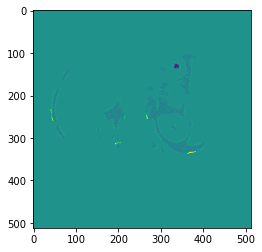

In [19]:
plt.imshow(img)

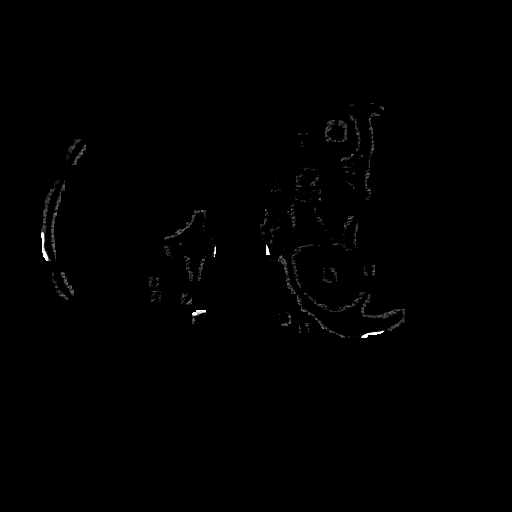

In [21]:
Image.fromarray(img*255
            )